In [146]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
pd.set_option('display.max_columns', None)

In [147]:
print("Enter your file choice: 1/2/3")
choice=int(input())
if choice==1:
    dataframe=pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
elif choice==2:
    dataframe1=pd.read_csv("adult/adult.data",header=None)
    dataframe2=pd.read_csv("adult/adult.test", header = None, skiprows=1)
elif choice==3:
    dataframe=pd.read_csv("creditcard.csv")
#dataframe
#print(dataframe.head(),5)

Enter your file choice: 1/2/3


In [148]:
def preprocessing(ch,df):
    if ch==3:
        #take random 20,000 data with Class 0 and all with class 1
        df1=df[df['Class']==1]
        df0=df[df['Class']==0].sample(n=20000,random_state=1)
        df=pd.concat([df0,df1])
    #replace empty string values with NaN
    df = df.replace(" ", np.nan)
    #replace missing values with columnwise mean for numeric columns
    numeric_cols = df.select_dtypes(include='number')
    df[numeric_cols.columns] = numeric_cols.fillna(numeric_cols.mean())
    #replace missing values with columnwise mode for non-numeric columns
    non_numeric_cols = df.select_dtypes(exclude='number')
    df[non_numeric_cols.columns] = non_numeric_cols.fillna(non_numeric_cols.mode().iloc[0])
    df[non_numeric_cols.columns] = df[non_numeric_cols.columns].replace('?', non_numeric_cols.mode().iloc[0])
    #remove duplicate rows
    df.drop_duplicates(inplace=True)

    if ch==1:
        features=dataframe.drop('Churn',axis=1)
        features.drop('customerID',axis=1,inplace=True)
        target=dataframe['Churn']
    elif ch==3:
        features=dataframe.drop('Class',axis=1)
        target=dataframe['Class']

    #label encoding target column
    encoder=LabelEncoder()
    target=encoder.fit_transform(target)

    #one hot encoding the categorical columns
    categorical_columns=[col for col in features if features[col].dtype == 'object']
    for col in categorical_columns:
        features=pd.get_dummies(features, columns=[col], drop_first=True)

    #min-max scaling the numeric columns
    scaler=MinMaxScaler()
    scale_columns=features.select_dtypes(exclude=['bool']).columns
    features[scale_columns]=scaler.fit_transform(features[scale_columns])

    features_df=pd.DataFrame(features,columns=features.columns)
    target_df=pd.DataFrame(target,columns=['Churn'])
    correlations=features_df.corrwith(target_df['Churn'])

    return features_df,target_df,correlations

In [149]:
def preprocessing_special(df1,df2):
    df1 = df1.replace("?", np.nan)
    df2 = df2.replace("?", np.nan)
    df1 = df1.replace(" ?",np.nan)
    df2 = df2.replace(" ?",np.nan)
    df1.columns=['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','Income']
    df2.columns=['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','Income']
    df1['Income'] = df1['Income'].str.replace('.','')
    df2['Income'] = df2['Income'].str.replace('.','')
    #replace missing values with columnwise mean for numeric columns
    numeric_cols = df1.select_dtypes(include='number')
    df1[numeric_cols.columns] = numeric_cols.fillna(numeric_cols.mean())
    #replace missing values with columnwise mode for non-numeric columns
    non_numeric_cols = df1.select_dtypes(exclude='number')
    df1[non_numeric_cols.columns] = non_numeric_cols.fillna(non_numeric_cols.mode().iloc[0])
    df1[non_numeric_cols.columns] = df1[non_numeric_cols.columns].replace('?', non_numeric_cols.mode().iloc[0])
    #remove duplicate rows
    df1.drop_duplicates(inplace=True)

    #replace missing values with columnwise mean for numeric columns
    numeric_cols = df2.select_dtypes(include='number')
    df2[numeric_cols.columns] = numeric_cols.fillna(numeric_cols.mean())
    #replace missing values with columnwise mode for non-numeric columns
    non_numeric_cols = df2.select_dtypes(exclude='number')
    df2[non_numeric_cols.columns] = non_numeric_cols.fillna(non_numeric_cols.mode().iloc[0])
    df2[non_numeric_cols.columns] = df2[non_numeric_cols.columns].replace('?', non_numeric_cols.mode().iloc[0])
    #remove duplicate rows
    df2.drop_duplicates(inplace=True)
    dataframe = pd.concat([df1,df2], ignore_index=True)
    features=dataframe.drop('Income',axis=1)
    target=dataframe['Income']

    #label encoding target column
    encoder=LabelEncoder()
    target=encoder.fit_transform(target)

    #one hot encoding the categorical columns
    categorical_columns=[col for col in features if features[col].dtype == 'object']
    for col in categorical_columns:
        features=pd.get_dummies(features, columns=[col], drop_first=True)

    #min-max scaling the numeric columns
    scaler=MinMaxScaler()
    scale_columns=features.select_dtypes(exclude=['bool']).columns
    features[scale_columns]=scaler.fit_transform(features[scale_columns])

    features_df=pd.DataFrame(features,columns=features.columns)
    target_df=pd.DataFrame(target,columns=['Income'])
    correlations=features_df.corrwith(target_df['Income'])

    return features_df,target_df,correlations

In [150]:
if choice==2:
    feature_processed, target_processed, correlations = preprocessing_special(dataframe1,dataframe2)
else:
    feature_processed, target_processed, correlations = preprocessing(choice, dataframe)
norm = Normalizer()
feature_normalized = norm.fit_transform(feature_processed)
#feature_processed

In [151]:
top_20_correlations=correlations.abs().sort_values(ascending=False).head(20)

feature_processed_df=pd.DataFrame(feature_normalized,columns=feature_processed.columns)
feature_processed_df=feature_processed_df[top_20_correlations.index]


In [152]:
#Logistic regression

class LogisticRegressionModel:
    def __init__(self, learning_rate=0.5, iterations=10000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = 0

    # Sigmoid function
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    # Cost function (Binary Cross-Entropy)
    def compute_cost(self, X, y):
        m = X.shape[0]
        predictions = self.predict_probabilities(X)
        cost = -(1/m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        return cost

    # Function for predicting probabilities
    def predict_probabilities(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    # Gradient Descent for updating weights and bias
    def gradient_descent(self, X, y):
        m = X.shape[0]
        
        for i in range(self.iterations):
            predictions = self.predict_probabilities(X)
            
            # Compute gradients
            dw = (1/m) * np.dot(X.T, (predictions - y))
            db = (1/m) * np.sum(predictions - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Fit function to train the model
    def fit(self, X, y):
        n_features = X.shape[1]
        self.weights = np.zeros(n_features)  # Initialize weights as zeros
        self.bias = 0
        
        # Perform gradient descent
        self.gradient_descent(X, y)
    
    # Prediction function (classify based on a threshold, default 0.5)
    def predict(self, X, threshold=0.5):
        probabilities = self.predict_probabilities(X)
        return [1 if prob >= threshold else 0 for prob in probabilities]

X_train, X_test, y_train, y_test = train_test_split(feature_processed_df, target_processed, test_size=0.2, random_state=42)
model = LogisticRegressionModel()
model.fit(X_train, np.array(y_train).flatten())
y_pred = model.predict(X_test)

# Output accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Logistic Regression classifier: {accuracy:.2f}")



Accuracy of Logistic Regression classifier: 0.83


In [153]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc

def stats(y_test,y_pred):
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Sensitivity (Recall)
    sensitivity = recall_score(y_test, y_pred)

    # Specificity
    specificity = tn / (tn + fp)

    # Precision
    precision = precision_score(y_test, y_pred, zero_division=1)

    # F1-Score
    f1 = f1_score(y_test, y_pred)

    # AUROC (Area under ROC curve)
    auroc = roc_auc_score(y_test, y_pred)

    # Precision-Recall curve and AUPR
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
    aupr = auc(recall_curve, precision_curve)

    # Output the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print(f"AUPR: {aupr:.4f}")



# Bagging

In [154]:
num_bootstrap_samples=9
bootstrap_samples=[]

X_train_np = X_train.to_numpy()  # Convert X_train to a NumPy array

for i in range(num_bootstrap_samples):
    bootstrap_indices=np.random.choice(range(len(X_train)),len(X_train),replace=True)
    bootstrap_X=X_train.iloc[bootstrap_indices]
    bootstrap_y=y_train.iloc[bootstrap_indices]
    bootstrap_samples.append((bootstrap_X, bootstrap_y))

lr_models=[]
predictions=[]
for x,y in bootstrap_samples:
    clf=LogisticRegressionModel()
    clf.fit(x,np.array(y).flatten())
    lr_models.append(clf)

metrics = {
    'accuracy': [],
    'sensitivity': [],
    'specificity': [],
    'precision': [],
    'f1_score': [],
    'auroc': [],
    'aupr': []
}
    
for model in lr_models:
    y_pred_class = model.predict(X_test)
    predictions.append(y_pred_class)
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred_class).ravel()

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred_class)
    
    # Sensitivity (Recall)
    sensitivity = recall_score(y_test, y_pred_class)
    
    # Specificity (calculated manually)
    specificity = tn / (tn + fp)
    
    # Precision
    precision = precision_score(y_test, y_pred_class, zero_division=1)
    
    # F1-Score
    f1 = f1_score(y_test, y_pred_class)
    
    # AUROC (Area under ROC curve)
    auroc = roc_auc_score(y_test, y_pred_class)
    
    # Precision-Recall curve and AUPR
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_class)
    aupr = auc(recall_curve, precision_curve)
    
    # Store metrics for this model
    metrics['accuracy'].append(accuracy)
    metrics['sensitivity'].append(sensitivity)
    metrics['specificity'].append(specificity)
    metrics['precision'].append(precision)
    metrics['f1_score'].append(f1)
    metrics['auroc'].append(auroc)
    metrics['aupr'].append(aupr)

# Calculate average and standard deviation for each metric
avg_metrics = {metric: np.mean(values) for metric, values in metrics.items()}
std_metrics = {metric: np.std(values) for metric, values in metrics.items()}

# Display average and standard deviation for each metric
print("Average and Standard Deviation of Metrics for LR:")
for metric in metrics.keys():
    print(f"{metric.capitalize()}: {avg_metrics[metric]:.4f} ± {std_metrics[metric]:.4f}")

#Majority voting

predictions=np.array(predictions)
aggregated_predictions=np.mean(predictions,axis=0)

# Round the aggregated predictions to the nearest integer
aggregated_predictions = np.round(aggregated_predictions)

#bagging_accuracy=accuracy_score(y_test,aggregated_predictions)
#print(f"Accuracy of Bagging classifier: {bagging_accuracy:.2f}")

print("Stats of Bagging classifier:")
stats(y_test, aggregated_predictions)

Average and Standard Deviation of Metrics for LR:
Accuracy: 0.8323 ± 0.0004
Sensitivity: 0.5157 ± 0.0028
Specificity: 0.9349 ± 0.0008
Precision: 0.7194 ± 0.0017
F1_score: 0.6007 ± 0.0016
Auroc: 0.7253 ± 0.0010
Aupr: 0.6768 ± 0.0008
Stats of Bagging classifier:
Accuracy: 0.8324
Sensitivity (Recall): 0.5163
Specificity: 0.9348
Precision: 0.7194
F1-Score: 0.6012
AUROC: 0.7256
AUPR: 0.6770


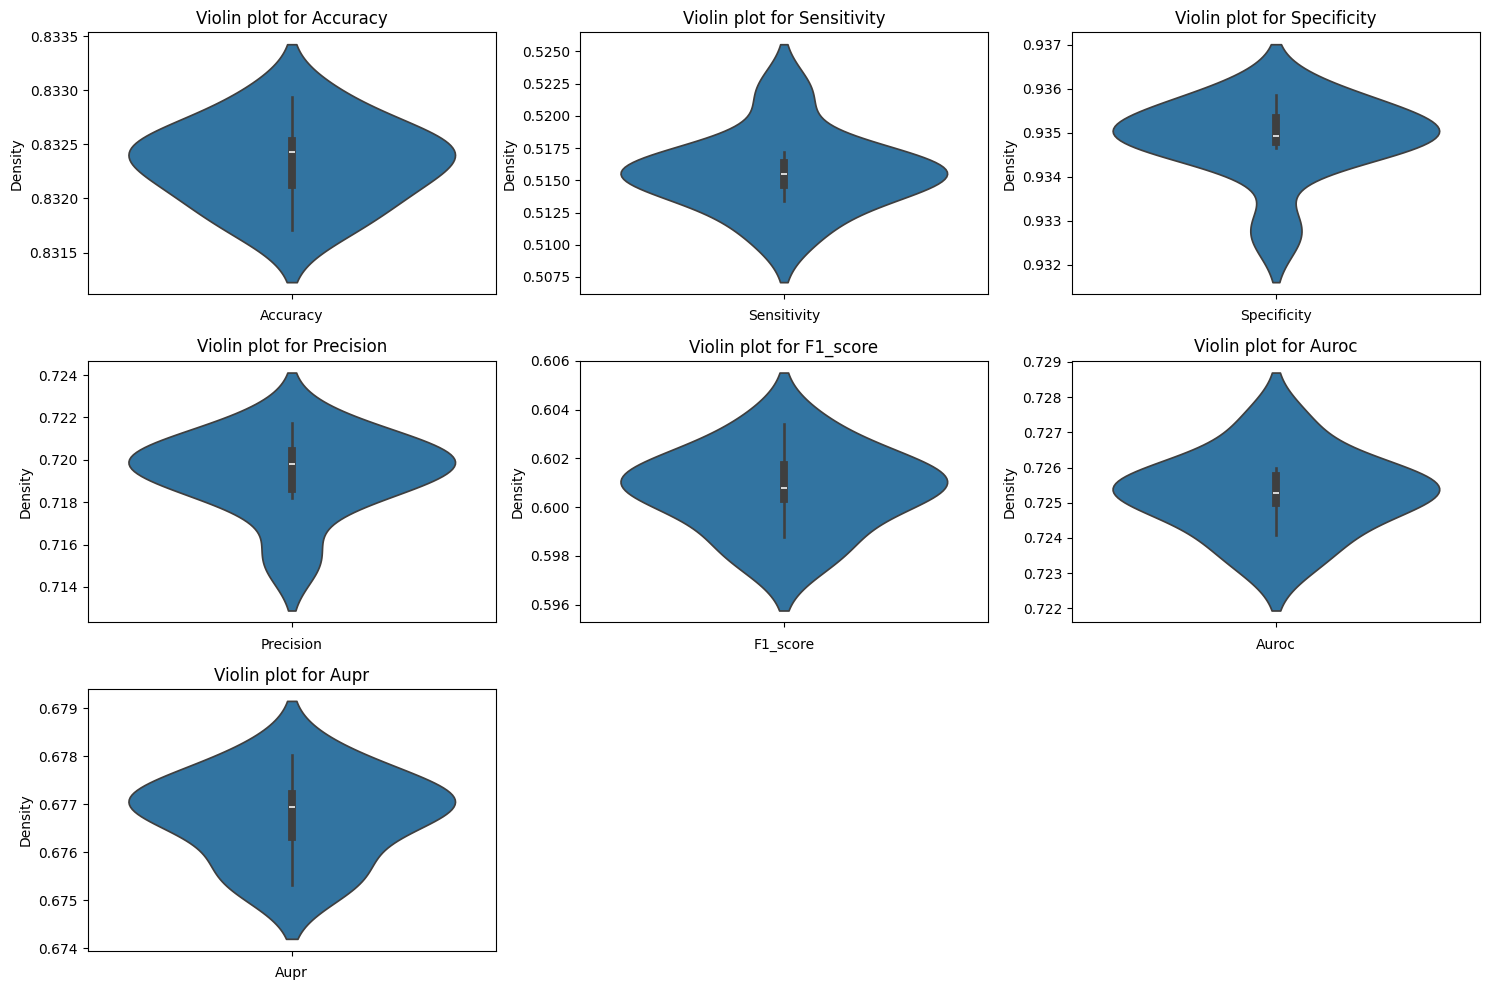

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert metrics to a DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics)

# Create a figure and subplots for each metric
plt.figure(figsize=(15, 10))

# Define the metric names for plotting
metric_names = ['accuracy', 'sensitivity', 'specificity', 'precision', 'f1_score', 'auroc', 'aupr']

# Plot each metric as a violin plot
for i, metric in enumerate(metric_names):
    plt.subplot(3, 3, i + 1)  # Create subplots in a 3x3 grid
    sns.violinplot(data=metrics_df[metric])
    plt.title(f"Violin plot for {metric.capitalize()}")
    plt.xlabel(f"{metric.capitalize()}")
    plt.ylabel("Density")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


# Stacking

In [156]:
X_base_train, X_meta_train_split, y_base_train, y_meta_train_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)
# Create a new dataset with predictions from base models
meta_X = np.array([model.predict(X_test) for model in lr_models]).T
X_meta_train = np.array([model.predict(X_meta_train_split) for model in lr_models]).T

# Train a meta classifier (another LR model)
meta_model = LogisticRegressionModel()
meta_model.fit(X_meta_train, np.array(y_meta_train_split).flatten())

# Make predictions using the stacking ensemble
stacking_preds = meta_model.predict(np.array([model.predict(X_test) for model in lr_models]).T)

#stacking_acc = accuracy_score(y_test, np.round(stacking_preds))
#print(f"Stacking Ensemble Accuracy: {stacking_acc:.2f}")

stats(y_test, np.round(stacking_preds))

Accuracy: 0.8316
Sensitivity (Recall): 0.5105
Specificity: 0.9356
Precision: 0.7196
F1-Score: 0.5973
AUROC: 0.7230
AUPR: 0.6749
